# Differential gene expression analysis of human COVID-19 PBMCs

This chapter is a more detailed continuation of the Annotation subchapter which already introduced differential gene expression (DGE) as a tool to annotate clusters with cell types.
Here, we focus on more advanced use-cases of differential gene expression testing on more complex experimental designs which involve one or more conditions such as diseases, genetic knockouts or drugs.
In such cases we are commonly interested in the magnitude and significance of differences in gene expression patterns between the condition of interest and a reference. This reference can be everything but is commonly a healthy sample. This statistical test can be applied to arbitrary groups, but in the case of single-cell RNA-Seq is commonly applied on the cell type level.

The outcome of such an analysis could be genesets which effect and potentially  explain any observed phenotypes. These genesets can then be examined more closely with respect to, for example, affected pathways or induced cell cell communication changes.

A differential gene expression test usually returns the log2 fold-change and the adjusted p-value per compared genes per compared conditions. This list can then be sorted by p-value and investigated in more detail.

The popular student's t-test is one way of conducting such a test. However, it fails to take several single-cell RNA-seq peculiarities into account such as the the excess number of zeros originating from dropouts or the need for complex experimental designs. More specifically, very rarely does one have sufficient sample numbers to accurately estimate the variance without pooling information across genes. Moreover, raw counts are never an absolute measurements of expression for a specific gene within a given sample. The actual read number per gene depends on the efficiency of the library preparation, the amount of contamination from non-coding transcripts and the sequencing depth. It does therefore lack in both, sensitivity and specificity for single-cell RNA-seq, let alone experimental design flexibility.

As a result, differential gene expression testing is a classic bioinformatics problem which has been tackled by many tools already. Generally, the problem is currently being approached from two views, the sample-level view where expression is aggregated to create “pseudobulks” and then analysed with methods originally designed for bulk expression samples such as edgeR{cite}`Robinson2010` or DEseq2{cite}`Love2014` and the cell-level view where cells are modeled individually using generalized mixed effect models such as MAST{cite}`Finak2015` or glmmTMB{cite}`Brooks2017`. The consensus and robustness across datasets for DGE tools is low5,6. As previously described, although single-cell data contains technical noise artifacts such as dropout, zero-inflation and high cell-to-cell variability7,8,9, methods designed for bulk RNA-seq data performed favorably compared to methods explicitly designed for scRNA-seq data{cite}`Das2021`,{cite}`Soneson2018`,{cite}`Jaakkola2016`,{cite}`Squair2021`. Single-cell specific methods were found to be especially prone to wrongly labeling highly expressed genes as differentially expressed12.

A recent study highlighted the issue of pseudoreplication where inferential statistics is applied to biological replicates which are not statistically independent. Failing to account for the inherent correlation of replicates (cells from the same individual) inflates the false discovery rate (FDR)12,13,14. Therefore, batch effect correction or the aggregation of cell-type-specific expression values within an individual through either a sum, mean or random effect per individual, that is pseudobulk generation, should be applied prior to DGE analysis to account for within-sample correlations13. Generally, both, pseudobulk methods with sum aggregation such as edgeR, DESeq2, or Limma15 and mixed models such as MAST with random effect setting were found to be superior compared to naive methods, such as the popular Wilcoxon rank-sum test or Seurat’s16 latent models, which do not account for them14.

Hence, in this notebook, we demonstrate how to use two tools for DE analysis: edgeR with a quasi likelihood test and MAST with random effects. Since both edgeR and MAST are implemented in R, we use the anndata2ri package to be able to simultaneously work with AnnData objects in Python and SingeCellExperiment objects in R.

We use a publically available dataset of nearly 100,000 human PBMCs in this analysis, which contains healthy donors as well as COVID-19 patients.CITE https://www.ncbi.nlm.nih.gov/pmc/articles/PMC7405822/

## Environment setup

In [ ]:
import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
import seaborn as sns
import scanpy as sc
import pandas as pd
import numpy as np
import random

import rpy2.rinterface_lib.callbacks
import anndata2ri
import logging

from rpy2.robjects import pandas2ri
from rpy2.robjects import r

sc.settings.verbosity = 0
rpy2.rinterface_lib.callbacks.logger.setLevel(logging.ERROR)

pandas2ri.activate()
anndata2ri.activate()

%load_ext rpy2.ipython

In [ ]:
%%R
library(edgeR)
library(MAST)

## Preparing the COVID-19 PBMC dataset

The dataset we will be looking at in this notebook comes from a study that examined differences in mild and severe cases of COVID-19. The data contains human single-cell data from two reasearch institue, one in Berlin and one in Bonn. The original dataset has mass cytometry (CyTOF), droplet-based single-cell RNA-sequencing (scRNA-seq), multi-color flow cytometry (MCFC) and microwell-based scRNA-seq  measuremenets, but we concentrate our analysis on droplet-based scRNA-seq data so we limit our analysis to the Berlin cohort. This subset contains almost 100,000 peripheral blood mononuclear cells (PBMCs). We further subset the data to control and severe COVID-19 conditions and aim to find differentially expressed genes that are specific for this particular condition. The authors of the paper identified that monocytes and granulocytes undergo significant changes in severe COVID-19 cases. Therefore we additionally concentrate our analysis on those two subpopulations.

First, we load the full dataset.

In [ ]:
adata = sc.read('/storage/groups/ml01/workspace/anastasia.litinetskaya/bp/Schulte_Schrepping_PBMC_10X_Berlin_cohort_rnaseq.h5ad')
adata

AnnData object with n_obs × n_vars = 99049 × 46584
    obs: 'Row.names', 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'nReads_RNA', 'nReads_ALL', 'percent.mito', 'percent.hb', 'donor', 'onset_of_symptoms', 'days_after_onset', 'sampleID', 'origID', 'date_of_sampling', 'DaysAfterSample0', 'experiment', 'PoolID', 'sampletag', 'hash.ID', 'platform', 'purification', 'cells', 'age', 'sex', 'group_per_sample', 'who_per_sample', 'disease_stage', 'outcome', 'comorbidities', 'COVID.19.related_medication_and_anti.microbials', 'RNA_snn_res.0.4', 'cluster_labels_res.0.4', 'new.order', 'id.celltype', 'hpca.labels', 'blueprint.labels', 'monaco.labels', 'immune.labels', 'dmap.labels', 'hemato.labels', 'nCount_SCT', 'nFeature_SCT', 'mapping.score', 'predicted.celltype.l1.COVID19.score', 'predicted.celltype.l1.COVID19', 'predicted.celltype.l2.COVID19.score', 'predicted.celltype.l2.COVID19', 'predicted.celltype.l1.citeseq.score', 'predicted.celltype.l1.citeseq', 'predicted.celltype.l2.citeseq.score', 'pre

We will need to work with raw counts so we check that `.X` indeed contains raw counts and put them into the `counts` layer of our AnnData object.

In [ ]:
np.max(adata.X)

49066.0

In [ ]:
adata.layers['counts'] = adata.X.copy()

Afterwards, we need to subset the full data to our conditions of interest. We also create cleaner metadata names.

In [ ]:
adata.obs['condition'] = adata.obs['group_per_sample'].copy()
adata.obs['cell_identity'] = adata.obs['hemato.labels'].copy()

In [ ]:
adata = adata[adata.obs['condition'].isin(['control', 'severe'])]
adata

View of AnnData object with n_obs × n_vars = 80854 × 46584
    obs: 'Row.names', 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'nReads_RNA', 'nReads_ALL', 'percent.mito', 'percent.hb', 'donor', 'onset_of_symptoms', 'days_after_onset', 'sampleID', 'origID', 'date_of_sampling', 'DaysAfterSample0', 'experiment', 'PoolID', 'sampletag', 'hash.ID', 'platform', 'purification', 'cells', 'age', 'sex', 'group_per_sample', 'who_per_sample', 'disease_stage', 'outcome', 'comorbidities', 'COVID.19.related_medication_and_anti.microbials', 'RNA_snn_res.0.4', 'cluster_labels_res.0.4', 'new.order', 'id.celltype', 'hpca.labels', 'blueprint.labels', 'monaco.labels', 'immune.labels', 'dmap.labels', 'hemato.labels', 'nCount_SCT', 'nFeature_SCT', 'mapping.score', 'predicted.celltype.l1.COVID19.score', 'predicted.celltype.l1.COVID19', 'predicted.celltype.l2.COVID19.score', 'predicted.celltype.l2.COVID19', 'predicted.celltype.l1.citeseq.score', 'predicted.celltype.l1.citeseq', 'predicted.celltype.l2.citeseq.scor

We also restrict our control samples to one study (Reyes et al., Nat Med, 2020)

In [ ]:
adata = adata[~((adata.obs['condition'] == 'control') & (adata.obs['experiment'] != 'Reyes et al., Nat Med, 2020'))]

After subsetting, we have 19 control and 10 disease patients.

In [ ]:
len(adata[adata.obs['condition'] == 'severe'].obs['donor'].cat.categories)

10

In [ ]:
len(adata[adata.obs['condition'] == 'control'].obs['donor'].cat.categories)

19

We filter cells which have less than 200 genes and genes which were found in less than 3 cells for a rudimentary quality control.

In [ ]:
sc.pp.filter_cells(adata, min_genes=200)
sc.pp.filter_genes(adata, min_cells=3)
adata

Trying to set attribute `.obs` of view, copying.


AnnData object with n_obs × n_vars = 63725 × 27377
    obs: 'Row.names', 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'nReads_RNA', 'nReads_ALL', 'percent.mito', 'percent.hb', 'donor', 'onset_of_symptoms', 'days_after_onset', 'sampleID', 'origID', 'date_of_sampling', 'DaysAfterSample0', 'experiment', 'PoolID', 'sampletag', 'hash.ID', 'platform', 'purification', 'cells', 'age', 'sex', 'group_per_sample', 'who_per_sample', 'disease_stage', 'outcome', 'comorbidities', 'COVID.19.related_medication_and_anti.microbials', 'RNA_snn_res.0.4', 'cluster_labels_res.0.4', 'new.order', 'id.celltype', 'hpca.labels', 'blueprint.labels', 'monaco.labels', 'immune.labels', 'dmap.labels', 'hemato.labels', 'nCount_SCT', 'nFeature_SCT', 'mapping.score', 'predicted.celltype.l1.COVID19.score', 'predicted.celltype.l1.COVID19', 'predicted.celltype.l2.COVID19.score', 'predicted.celltype.l2.COVID19', 'predicted.celltype.l1.citeseq.score', 'predicted.celltype.l1.citeseq', 'predicted.celltype.l2.citeseq.score', 'pre

## edgeR

edgeR is a differential gene expression testing tool implemented in R which was initially designed for bulk gene expression data. It implements a wide range of statistical methodology based on the negative binomial distribution, empirical Bayes estimation, exact tests, generalized linear models (GLMs) and quasi-likelihood tests.

For more details please read the original publication CITE IT.

Here, we will be using the quasi likelihood test because it accounts for the uncertainty of the dispersion estimates. In contrast, the exact test assumes that the estimated dispersion is the true value, which can result in some inaccuracy. Additionally, the quasi likelihood GLMs are more flexible when it comes to experimental design.

Since edgeR was introduced as a method for DE analysis for bulk data, we first need to create pseudo-bulk samples from our single-cell dataset. For each patient we create 3 pseudo-replicates with approximately the same numbder of cells by sampling without replacement. We repeat the gene filtering step for each of the conditions because we do not know if zeros in the count matrix are true zeros or results of drop-outs. We would not be able to draw meaningful conclusions about biological differences for genes that are expressed in one condition and not expressed in the other.

The final design matrix for our experiment is then `~ condition + donor` to account for patient variability. We strongly recommend to read this guide https://f1000research.com/articles/9-1444 on design matrices.

First, we repeat the filtering step for each condition separately.

In [ ]:
severe = adata[adata.obs['condition'] == 'severe'].copy()
control = adata[adata.obs['condition'] == 'control'].copy()
severe, control

(AnnData object with n_obs × n_vars = 30071 × 27377
     obs: 'Row.names', 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'nReads_RNA', 'nReads_ALL', 'percent.mito', 'percent.hb', 'donor', 'onset_of_symptoms', 'days_after_onset', 'sampleID', 'origID', 'date_of_sampling', 'DaysAfterSample0', 'experiment', 'PoolID', 'sampletag', 'hash.ID', 'platform', 'purification', 'cells', 'age', 'sex', 'group_per_sample', 'who_per_sample', 'disease_stage', 'outcome', 'comorbidities', 'COVID.19.related_medication_and_anti.microbials', 'RNA_snn_res.0.4', 'cluster_labels_res.0.4', 'new.order', 'id.celltype', 'hpca.labels', 'blueprint.labels', 'monaco.labels', 'immune.labels', 'dmap.labels', 'hemato.labels', 'nCount_SCT', 'nFeature_SCT', 'mapping.score', 'predicted.celltype.l1.COVID19.score', 'predicted.celltype.l1.COVID19', 'predicted.celltype.l2.COVID19.score', 'predicted.celltype.l2.COVID19', 'predicted.celltype.l1.citeseq.score', 'predicted.celltype.l1.citeseq', 'predicted.celltype.l2.citeseq.score', 'p

We remove genes that are expressed in fewer than 3 cells in both groups.

In [ ]:
sc.pp.filter_genes(severe, min_cells=3)
severe

AnnData object with n_obs × n_vars = 30071 × 22799
    obs: 'Row.names', 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'nReads_RNA', 'nReads_ALL', 'percent.mito', 'percent.hb', 'donor', 'onset_of_symptoms', 'days_after_onset', 'sampleID', 'origID', 'date_of_sampling', 'DaysAfterSample0', 'experiment', 'PoolID', 'sampletag', 'hash.ID', 'platform', 'purification', 'cells', 'age', 'sex', 'group_per_sample', 'who_per_sample', 'disease_stage', 'outcome', 'comorbidities', 'COVID.19.related_medication_and_anti.microbials', 'RNA_snn_res.0.4', 'cluster_labels_res.0.4', 'new.order', 'id.celltype', 'hpca.labels', 'blueprint.labels', 'monaco.labels', 'immune.labels', 'dmap.labels', 'hemato.labels', 'nCount_SCT', 'nFeature_SCT', 'mapping.score', 'predicted.celltype.l1.COVID19.score', 'predicted.celltype.l1.COVID19', 'predicted.celltype.l2.COVID19.score', 'predicted.celltype.l2.COVID19', 'predicted.celltype.l1.citeseq.score', 'predicted.celltype.l1.citeseq', 'predicted.celltype.l2.citeseq.score', 'pre

In [ ]:
sc.pp.filter_genes(control, min_cells=3)
control

AnnData object with n_obs × n_vars = 33654 × 20000
    obs: 'Row.names', 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'nReads_RNA', 'nReads_ALL', 'percent.mito', 'percent.hb', 'donor', 'onset_of_symptoms', 'days_after_onset', 'sampleID', 'origID', 'date_of_sampling', 'DaysAfterSample0', 'experiment', 'PoolID', 'sampletag', 'hash.ID', 'platform', 'purification', 'cells', 'age', 'sex', 'group_per_sample', 'who_per_sample', 'disease_stage', 'outcome', 'comorbidities', 'COVID.19.related_medication_and_anti.microbials', 'RNA_snn_res.0.4', 'cluster_labels_res.0.4', 'new.order', 'id.celltype', 'hpca.labels', 'blueprint.labels', 'monaco.labels', 'immune.labels', 'dmap.labels', 'hemato.labels', 'nCount_SCT', 'nFeature_SCT', 'mapping.score', 'predicted.celltype.l1.COVID19.score', 'predicted.celltype.l1.COVID19', 'predicted.celltype.l2.COVID19.score', 'predicted.celltype.l2.COVID19', 'predicted.celltype.l1.citeseq.score', 'predicted.celltype.l1.citeseq', 'predicted.celltype.l2.citeseq.score', 'pre

Finally, we concatenate again with inner join so we are left with genes that are expressed in both groups. This is the object that we will pass to edgeR.

In [ ]:
adata_pp = severe.concatenate(control, index_unique=None)
adata_pp

AnnData object with n_obs × n_vars = 63725 × 15501
    obs: 'Row.names', 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'nReads_RNA', 'nReads_ALL', 'percent.mito', 'percent.hb', 'donor', 'onset_of_symptoms', 'days_after_onset', 'sampleID', 'origID', 'date_of_sampling', 'DaysAfterSample0', 'experiment', 'PoolID', 'sampletag', 'hash.ID', 'platform', 'purification', 'cells', 'age', 'sex', 'group_per_sample', 'who_per_sample', 'disease_stage', 'outcome', 'comorbidities', 'COVID.19.related_medication_and_anti.microbials', 'RNA_snn_res.0.4', 'cluster_labels_res.0.4', 'new.order', 'id.celltype', 'hpca.labels', 'blueprint.labels', 'monaco.labels', 'immune.labels', 'dmap.labels', 'hemato.labels', 'nCount_SCT', 'nFeature_SCT', 'mapping.score', 'predicted.celltype.l1.COVID19.score', 'predicted.celltype.l1.COVID19', 'predicted.celltype.l2.COVID19.score', 'predicted.celltype.l2.COVID19', 'predicted.celltype.l1.citeseq.score', 'predicted.celltype.l1.citeseq', 'predicted.celltype.l2.citeseq.score', 'pre

Now, let's define the function we need to aggregate single cells into pseudo-replicates:
- `aggregate_and_filter` is a function that creates an AnnData object with 3 pseudo-replicates for each donor for a specified subpopulation from the original single-cell AnnData object. Here we also filter out donors that have fewer than 30 cells for the specified population.

In [ ]:
NUM_OF_CELL_PER_DONOR = 30

def aggregate_and_filter(
    adata, 
    cell_identity, 
    donor_key='donor', 
    condition_key='condition', 
    cell_identity_key='cell_identity',
    obs_to_keep=[], # which additional metadata to keep, e.g. gender, age, etc.
    replicates_per_patient=3,
):
    # subset adata to the given cell identity
    adata_cell_pop = adata[adata.obs[cell_identity_key] == cell_identity].copy()
    # re-filter for this cell population
    sc.pp.filter_genes(adata_cell_pop, min_cells=3)
    # check which donors to keep according to the number of cells specified with NUM_OF_CELL_PER_DONOR 
    size_by_donor = adata_cell_pop.obs.groupby([donor_key]).size()
    donors_to_drop = [donor for donor in size_by_donor.index if size_by_donor[donor] <= NUM_OF_CELL_PER_DONOR]
    df = pd.DataFrame(columns=[*adata_cell_pop.var_names, *obs_to_keep])
    
    adata_cell_pop.obs[donor_key] = adata_cell_pop.obs[donor_key].astype('category')
    for i, donor in enumerate(donors:=adata_cell_pop.obs[donor_key].cat.categories):
        print(f'Processing donor {i+1} out of {len(donors)}...', end='\r')
        if donor not in donors_to_drop:
            adata_donor = adata_cell_pop[adata_cell_pop.obs[donor_key] == donor]
            # create replicates for each donor
            indices = list(adata_donor.obs_names)
            random.shuffle(indices)
            indices = np.array_split(np.array(indices), replicates_per_patient)
            for i, rep_idx in enumerate(indices):
                adata_replicate = adata_donor[rep_idx]
                # specify how to aggregate: sum gene expression for each gene for each donor and also keep the condition information
                agg_dict = {gene: 'sum' for gene in adata_replicate.var_names}
                for obs in obs_to_keep:
                    agg_dict[obs] = 'first'
                # create a df with all genes, donor and condition info
                df_donor = pd.DataFrame(adata_replicate.X.A)
                df_donor.index = adata_replicate.obs_names
                df_donor.columns = adata_replicate.var_names
                df_donor = df_donor.join(adata_replicate.obs[obs_to_keep])
                # aggregate
                df_donor = df_donor.groupby(donor_key).agg(agg_dict)
                df_donor[donor_key] = donor
                df.loc[f'donor_{donor}_{i}'] = df_donor.loc[donor]
        
    # create AnnData object from the df
    adata_cell_pop = sc.AnnData(df[adata_cell_pop.var_names], obs=df.drop(columns=adata_cell_pop.var_names))
    return adata_cell_pop

We might want to look at available metadata later and therefore keep it in the AnnData object.

In [ ]:
obs_to_keep = ['donor', 'condition', 'cell_identity', 'platform', 'purification', 'cells', 'age', 'sex', 'who_per_sample', 'disease_stage', 'outcome']

We need to pass the raw counts to edgeR. Hence, we set `.X` to the `counts` layer to ensure the pseudo-replicates are created for raw counts.

In [ ]:
adata.X = adata.layers['counts'].copy()

First we run the analysis for granulocytes.

In [ ]:
%%time
adata_gran = aggregate_and_filter(adata_pp, 'Granulocytes', obs_to_keep=obs_to_keep)
adata_gran

CPU times: user 33min 9s, sys: 54.5 s, total: 34min 4s
Wall time: 33min 36s


AnnData object with n_obs × n_vars = 75 × 13209
    obs: 'donor', 'condition', 'cell_identity', 'platform', 'purification', 'cells', 'age', 'sex', 'who_per_sample', 'disease_stage', 'outcome'

The validity of differential gene expression results highly depend on the capturement of the major axis of variations in the statistical model. Intermediate data exploration steps such as principal component analysis (PCA) or multidimensional scaling (MDS) on pseudobulk samples allow for the identification of the sources of variation and thus can guide the construction of corresponding design and contrast matrices that model the data19. 

Failing to account for multiple sources of biological variability for experiments which include biological replicates will inflate the FDR20,21. While increasing the number of cells per individual increases the precision, it has a limited effect on the power for the detection of differences across individuals. Therefore, the best way to increase statistical power is to increase the number of independent experimental samples13. 

Since our data has already been generated, we cannot further increase the number of independent experimental samples. Nevertheless, we will now explore our data to determine the major axes of variation to properly generate our design matrices.

We perform very basic EDA on the created pseudo-replicates to check if some patients/pseudobulks are outliers that we need to exclude not to bias the DE results.

In [ ]:
sc.pp.pca(adata_gran)

In [ ]:
# set categorical metadata to be indeed categorical
adata_gran.obs['donor'] = adata_gran.obs['donor'].astype('category')
adata_gran.obs['condition'] = adata_gran.obs['condition'].astype('category')

Next, we look at created pseudo-replicates on a PCA plot and color by all the available metadata to see if there are any confounding factors that we might want to include in the design matrix. 

... storing 'cell_identity' as categorical
... storing 'platform' as categorical
... storing 'purification' as categorical
... storing 'cells' as categorical
... storing 'age' as categorical
... storing 'sex' as categorical
... storing 'disease_stage' as categorical
... storing 'outcome' as categorical


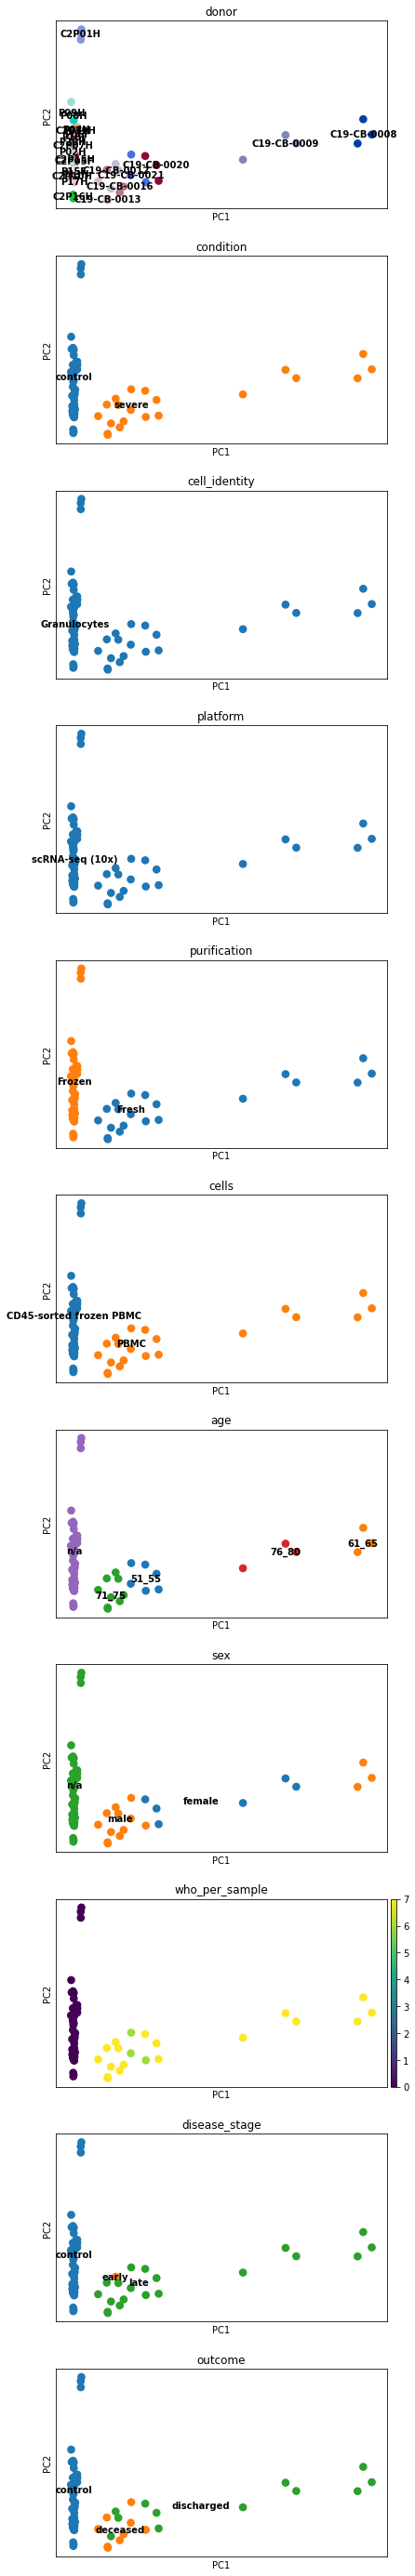

In [ ]:
sc.pl.pca(adata_gran, color=adata_gran.obs, ncols=1, size=300, legend_loc='on data')

There are two outliers in the severe group, namely the donors with labels `C19-CB-0009` and `C19-CB-0008`. We exclude them from further analysis.

Additionally, the first principal component seems to be confounded by variation that is not captured by any of the known metadata, so we do not include any additional factors other than donor information into the design matrix.

In [ ]:
# exclude outliers
adata_gran = adata_gran[~adata_gran.obs['donor'].isin(['C19-CB-0009', 'C19-CB-0008'])]
adata_gran

View of AnnData object with n_obs × n_vars = 69 × 13209
    obs: 'donor', 'condition', 'cell_identity', 'platform', 'purification', 'cells', 'age', 'sex', 'who_per_sample', 'disease_stage', 'outcome'
    uns: 'pca', 'donor_colors', 'condition_colors', 'cell_identity_colors', 'platform_colors', 'purification_colors', 'cells_colors', 'age_colors', 'sex_colors', 'disease_stage_colors', 'outcome_colors'
    obsm: 'X_pca'
    varm: 'PCs'

Now we are finally ready to run the edgeR pipeline. We define a separate function:
- `find_de_edgeR` takes a SingleCellExperiment object as input and runs standard edgeR pipeline. The function returns a new SingleCellExperiment object which contains results of the analysis, e.g. log-fold change and p-value for each gene, an edgeR object of class DGEList, the table with results for each gene and the fitted GLM.

In [ ]:
%%R
find_de_edgeR <- function(adata_){
    # create an edgeR object with counts and grouping factor
    y <- DGEList(assay(adata_, "X"), group = colData(adata_)$condition)
    # filter out genes with low counts
    print("Dimensions before subsetting:")
    print(dim(y))
    print("")
    keep <- filterByExpr(y)
    y <- y[keep, , keep.lib.sizes=FALSE]
    print("Dimensions after subsetting:")
    print(dim(y))
    print("")
    y <- calcNormFactors(y)
    # create a design matrix: here we have multiple donors so also consider that in the design matrix
    design <- model.matrix(~ colData(adata_)$condition + colData(adata_)$donor)
    # when we have both condition and donor information in the design matrix, it becomes not full rank
    # i.e. sum over condition columns minus sum over donor columns = 0
    # so we remove the last column so the matrix has full rank again
    design <- design[,-ncol(design)]
    print("Head of the design matrix after removing the last column:")
    print(head(design))
    print("")
    y <- estimateDisp(y, design = design)
    fit <- glmQLFit(y, design)
    # here we have two conditions and interested in differences between them, so look at the corresponding coefficient
    qlf <- glmQLFTest(fit, coef=2)
    # get all of the DE genes and calculate Benjamini-Hochberg adjusted FDR
    tt <- topTags(qlf, n = Inf)
    print("Head of the table with the test results:")
    print(head(tt))
    counts = data.matrix(tt$table)
    res = SingleCellExperiment(assays = list(counts = counts))
    
    return(list("sc" = as(res, 'SingleCellExperiment'), "y" = y, "tt" = tt, "qlf" = qlf, "design" = design))
}

In [ ]:
%%time
%%R -i adata_gran -o outputs
outputs <- find_de_edgeR(adata_gran)

[1] "Dimensions before subsetting:"
[1] 13209    69
[1] ""
[1] "Dimensions after subsetting:"
[1] 1103   69
[1] ""
[1] "Head of the design matrix after removing the last column:"
  (Intercept) colData(adata_)$conditionsevere colData(adata_)$donorC19-CB-0013
1           1                               1                                0
2           1                               1                                0
3           1                               1                                0
4           1                               1                                1
5           1                               1                                1
6           1                               1                                1
  colData(adata_)$donorC19-CB-0016 colData(adata_)$donorC19-CB-0020
1                                0                                0
2                                0                                0
3                                0                              

In [ ]:
%%R -o res_gran
res_gran <- outputs$sc
y <- outputs$y
tt <- outputs$tt
qlf <- outputs$qlf
design <- outputs$design

One can also test for genes that are differentially expressed for a provided coefficient or contrast relative to a specified fold-change using `glmTreat`.

In [ ]:
%%R
fit <- glmQLFit(y, design)
tr <- glmTreat(fit, coef=2, lfc=1.5)
print(head(topTags(tr)))

Coefficient:  colData(adata_)$conditionsevere 
           logFC unshrunk.logFC   logCPM       PValue          FDR
RPS17  -5.692482      -5.718189 11.90703 2.415194e-28 2.663959e-25
RPL36A -4.874053      -4.889164 11.53996 6.168954e-27 3.402178e-24
RPS27  -2.935878      -2.936423 14.33177 8.846861e-22 3.252696e-19
NBEAL1 -4.925705      -4.960025 10.58724 7.559164e-21 2.084440e-18
RPL31  -3.246269      -3.249498 12.24266 1.188264e-20 2.621311e-18
RPL17  -4.472863      -4.494509 10.50108 5.170729e-19 9.505524e-17


Since we did not enter our analysis with a prior assumption that a specific gene will be up- or downregulated, we need visualizations to make sense of the DGE results. MDS plots allow for a high level overview. Commonly, we expect a separation between samples from different conditions as can be seen in the following plot for our results.

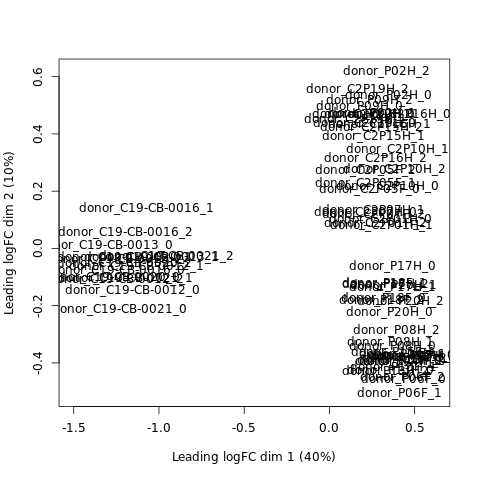

In [ ]:
%%R
plotMDS(y)

Biological Coefficient of Variation (BCV) plots show the variability of every gene on average across biological groups as a function of mean expression. For example, bcv of 0.3 indicates that there is on average 30% percent variability in the expression of genes across groups.

Genes with low abundace generally exhibit larger BCV as read count measurements are more uncertain for low abundance genes. On the other hand, genes with high average expression are quantified more reliably, thus they generally have lower variability and hence lower BCV. Use this plot to detect outlier genes or pinpoint other experimental factors that may need to be reflected in the design matrix. For example, a group of genes with high average expression and high BCV appearing in the top right corner of the plot can flag experimental stress, contamination etc, particularly if they belong to similar gene families.

BCV is the square root of dispersion. The distance between tagwise and common bcv trend indicate if tagwise (gene-wise) dispersion estimates are highly variable (i.e. heterogenous gene expression). If tag-wise dispersion values are very heterogenous, less moderation is applied to capture heterogenity. The distance between any two points on those curves reflects how much the dispersion for a gene was shrunken towards the common trend. That is, it captures the amount of dispersion moderation applied.  

In the BCV plot below, we see some low abundance genes with high bcv, but no high abundance genes with high bcv, which indicates that there should not be any further experimental considerations modelled into the design matrix.

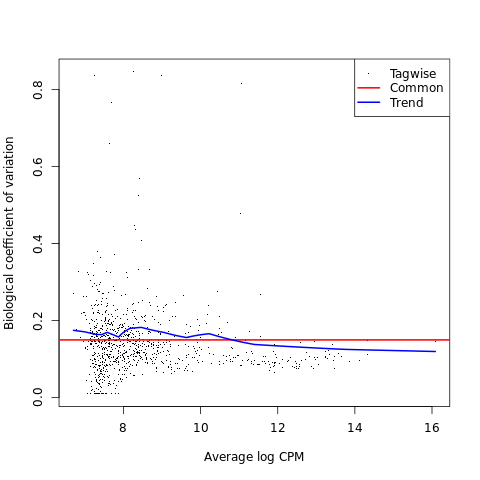

In [ ]:
%%R
plotBCV(y)

And finally, we can see how many genes we have with FDR-corrected values of less than 0.01.

The smear plot (also known as MA, M-values vs A-values, plot) shows the log fold-change of the genes as a function of their mean abundance. We generally observe higher logFC at low abundance ranges as read counts are more variable at low abundance resulting in large logFC estimates. If we fit a loess curve to logFC and Average logCPM values, the trend should center around zero. Any deviations from this can indicate that data has not been properly normalised. Genes with large mean expression and large logFC in absolute values can flag biologically interesting genes for investigation and follow-up.

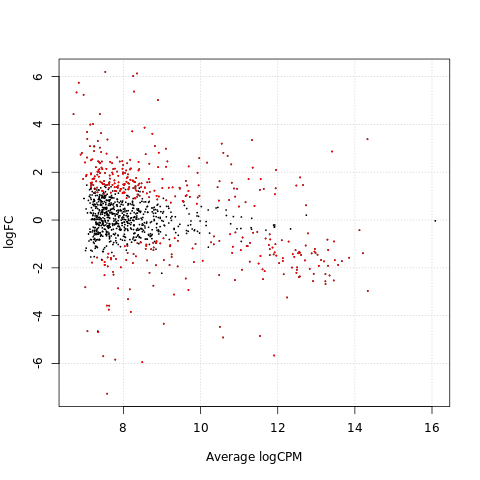

In [ ]:
%%R
plotSmear(qlf, de.tags = rownames(tt$table)[which(tt$table$FDR<0.01)])

Next we repeat the same analysis for monocytes.

In [ ]:
%%time
adata_mono = aggregate_and_filter(adata_pp, 'Monocytes', obs_to_keep=obs_to_keep)
adata_mono

CPU times: user 49min 44s, sys: 1min 6s, total: 50min 51s
Wall time: 50min 18s


AnnData object with n_obs × n_vars = 87 × 14980
    obs: 'donor', 'condition', 'cell_identity', 'platform', 'purification', 'cells', 'age', 'sex', 'who_per_sample', 'disease_stage', 'outcome'

We repeat basic EDA.

In [ ]:
sc.pp.pca(adata_mono)

In [ ]:
adata_mono.obs['donor'] = adata_mono.obs['donor'].astype('category')
adata_mono.obs['condition'] = adata_mono.obs['condition'].astype('category')

... storing 'cell_identity' as categorical
... storing 'platform' as categorical
... storing 'purification' as categorical
... storing 'cells' as categorical
... storing 'age' as categorical
... storing 'sex' as categorical
... storing 'disease_stage' as categorical
... storing 'outcome' as categorical


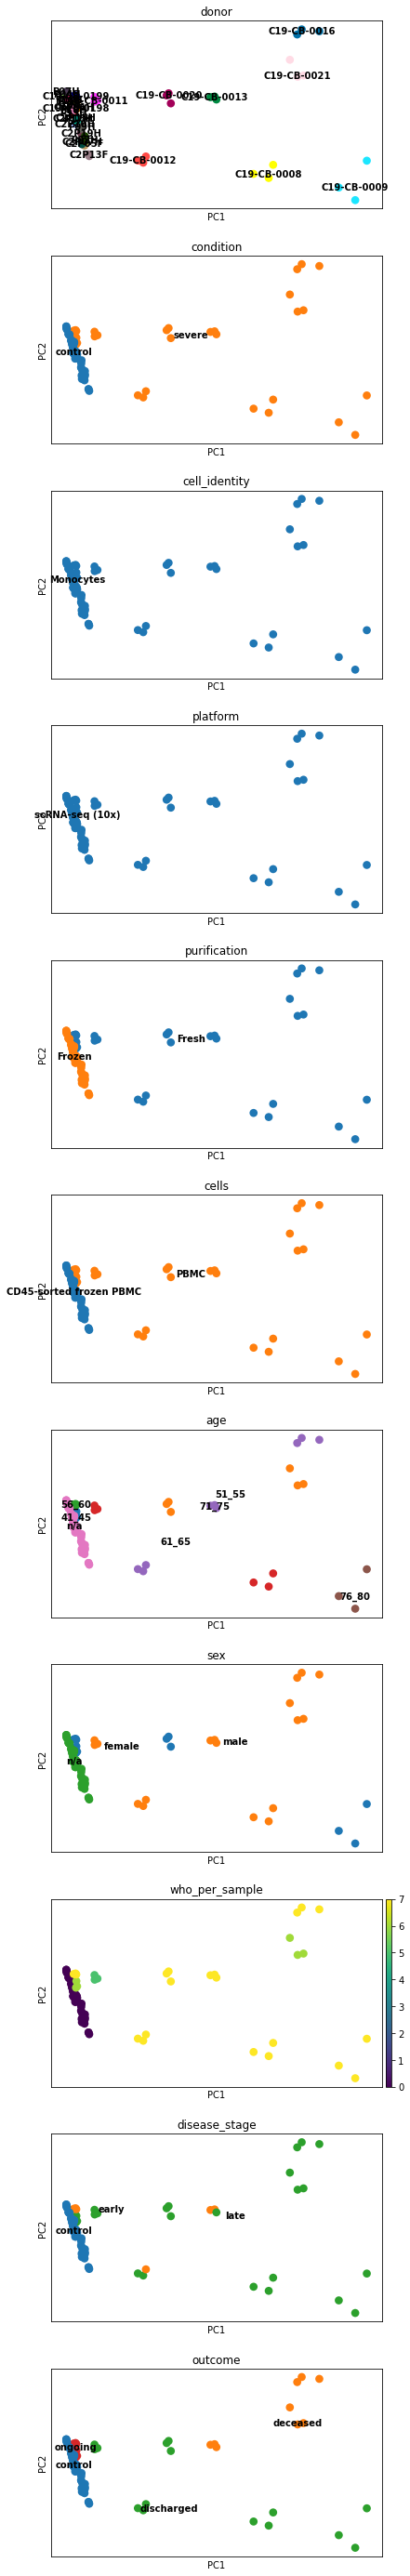

In [ ]:
sc.pl.pca(adata_mono, color=adata_mono.obs, ncols=1, size=300, legend_loc='on data')

Here we do not have such clear outliers so we do not exclude any of the samples and run the analysis on all pseudo-replicates.

In [ ]:
%%time
%%R -i adata_mono -o outputs
outputs <- find_de_edgeR(adata_mono)

[1] "Dimensions before subsetting:"
[1] 14980    87
[1] ""
[1] "Dimensions after subsetting:"
[1] 5461   87
[1] ""
CPU times: user 50.4 s, sys: 47.6 s, total: 1min 38s
Wall time: 46.8 s


In [ ]:
%%R -o res_mono
res_mono <- outputs$sc
y <- outputs$y
tt <- outputs$tt
qlf <- outputs$qlf

The MDS plot again shows a good separation between conditions.

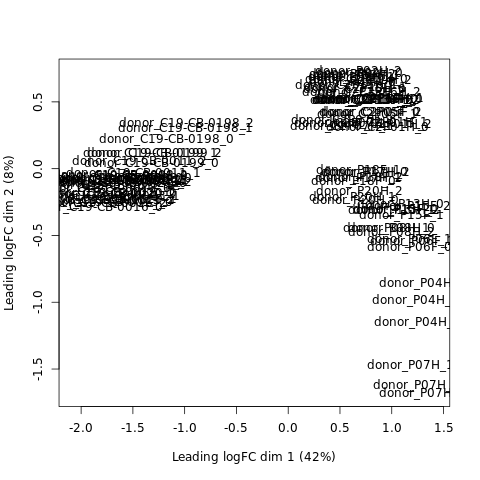

In [ ]:
%%R
plotMDS(y)

We see some low abundace genes with high bcv here. We can label those genes, but there should not be any concerns here.

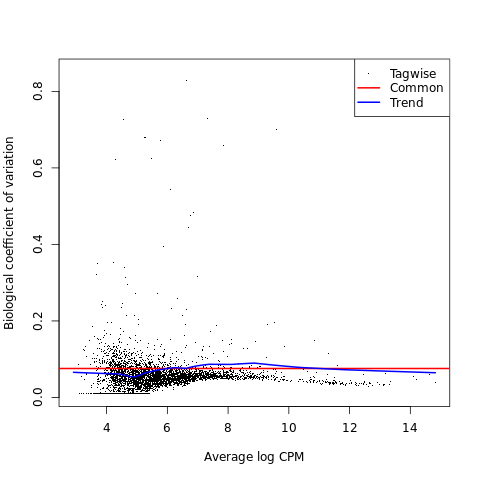

In [ ]:
%%R
plotBCV(y)

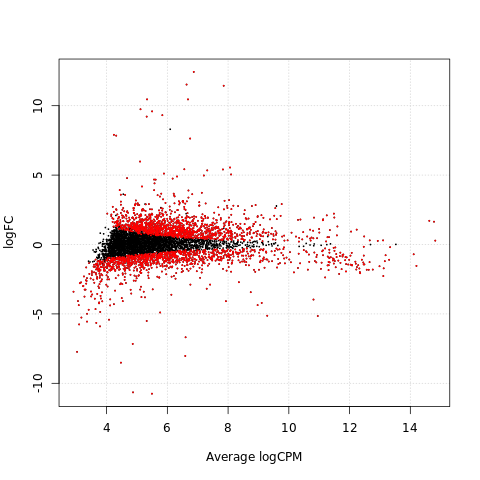

In [ ]:
%%R
plotSmear(qlf, de.tags = rownames(tt$table)[which(tt$table$FDR<0.01)])

From these plots we can see that compared to granulocytes, we obtained a higher number of DE genes for monocytes.

We can additionally visualize results with a heatmap and a volcano plot. Each row of a heatmap corresponds to a gene and each column to a single-cell. The brighter the color is the higher is the expresion of that gene in a particular cell. Since we only plot DE genes, we would like to see clear differences in expression between the two conditions. Volcano plots are often used to visualize results of statistical testing, and they show the change in expression on the x-axis (log-fold change) and statistical significance on the y-axis (FDR-corrected p-values). We color code the genes that have FDR-corrected p-value under 0.01 and log-fold change of over 1.5

We need to define an additional helper funcion to clean up the results and store it in the original AnnData object. We store the output of the edgeR analysis in `.varm` where data for genes that were not used is set to `np.nan`.

In [ ]:
def prep_result(adata_res, adata):
    result = pd.DataFrame(adata_res.X.T, index=adata_res.var_names, columns=adata_res.obs_names)
    result = pd.DataFrame(index=adata.var_names).join(result, how='outer')
    result = result.T[adata.var_names].T
    return result

In [ ]:
res_gran

AnnData object with n_obs × n_vars = 5 × 1083

In [ ]:
res_mono

AnnData object with n_obs × n_vars = 5 × 5461

We store the results of the edgeR analysis in `.varm` of the preprocessed AnnData object.

In [ ]:
adata_pp.varm['edgeR_granulocytes'] = prep_result(res_gran, adata_pp)
adata_pp.varm['edgeR_monocytes'] = prep_result(res_mono, adata_pp)
adata_pp

AnnData object with n_obs × n_vars = 63725 × 15501
    obs: 'donor', 'condition', 'cell_identity', 'platform', 'purification', 'cells', 'age', 'sex', 'group_per_sample', 'who_per_sample', 'disease_stage', 'outcome', 'n_genes', 'batch'
    var: 'n_cells-0', 'n_cells-1'
    varm: 'edgeR_granulocytes', 'edgeR_monocytes'

We can quickly take a look of what the output table looks like. We are interested in FDR-corrected p-values that are stored in FDR column and log-fold change stored in logFC column.

In [ ]:
adata_pp.varm['edgeR_granulocytes'].dropna().sort_values('logFC', ascending=False)

,logFC,logCPM,F,PValue,FDR,-logQ
S100P,6.195858,7.529244,93.680298,2.464194e-13,3.294719e-12,26.438700
RPS4Y1,6.130698,8.352696,83.835197,6.018926e-13,7.668820e-12,25.593859
CXCL8,6.025499,8.251882,70.334969,4.152945e-10,3.844137e-09,19.376717
FOSB,5.742328,6.841267,50.675110,2.350864e-09,1.879959e-08,17.789431
RETN,5.374373,8.275250,74.171013,2.945938e-12,3.467881e-11,24.084892
...,...,...,...,...,...,...
RPS17,-5.666752,11.907924,860.791321,1.487547e-38,1.611014e-35,80.113617
MS4A1,-5.697968,7.476444,16.463888,1.519071e-04,5.520649e-04,7.501845
CD79B,-5.839272,7.787713,21.559813,1.860750e-05,8.467193e-05,9.376726
ZNF90,-5.946415,8.487720,92.572533,1.443975e-13,1.954781e-12,26.960743


In [ ]:
adata_pp.varm['edgeR_monocytes'].dropna().sort_values('logFC', ascending=False)

,logFC,logCPM,F,PValue,FDR,-logQ
LCN2,12.434523,6.869434,87.729362,1.598935e-13,1.781996e-12,27.053288
FCGR3B,11.523978,6.632944,334.420990,1.127355e-29,4.594392e-28,62.947548
RPS4Y1,11.438132,7.854853,572.287720,2.740433e-37,1.644561e-35,80.093002
SLPI,10.456722,5.332150,108.700386,4.442105e-16,6.300867e-15,32.698090
IFI27,10.454596,6.679850,40.995224,1.214654e-08,7.386663e-08,16.421005
...,...,...,...,...,...,...
AC245100.1,-7.732700,3.027743,108.725807,1.225134e-15,1.672614e-14,31.721804
ZNF90,-8.030133,6.591205,1157.500122,0.000000e+00,0.000000e+00,inf
NACA2,-8.513414,4.471872,379.455200,1.253660e-32,6.005471e-31,69.587463
GREM1,-10.651922,4.870068,888.295227,2.802597e-45,2.438259e-43,98.119873


We normalize the data before plotting the heatmaps to see the differences in expression between two conditions better.

In [ ]:
adata_pp.layers['counts'] = adata_pp.X.copy()
sc.pp.normalize_total(adata_pp, target_sum=1e6)
sc.pp.log1p(adata_pp)

Next, we define a helper plotting function for the heatmaps.

In [ ]:
FDR = 0.01
LOG_FOLD_CHANGE = 1.5

def plot_heatmap(adata, res, cell_identity):
    res = res[(res['FDR'] < FDR) & (abs(res['logFC']) > LOG_FOLD_CHANGE)].sort_values(by=['logFC'])
    print(f"Plotting {len(res)} genes...")
    markers = list(res.index)
    sc.pl.heatmap(adata[adata.obs['cell_identity'] == cell_identity].copy(), markers, groupby='condition', swap_axes=True)

And finally we can plot the heatmaps for granulocytes and monocytes.

Plotting 233 genes...


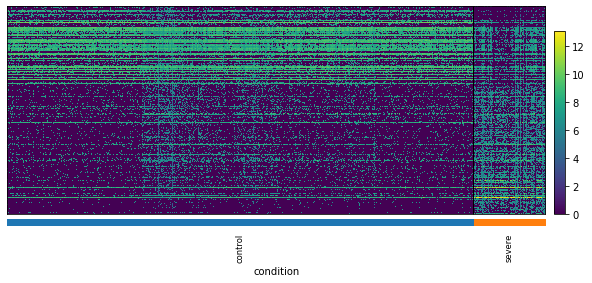

In [ ]:
plot_heatmap(adata_pp, adata_pp.varm['edgeR_granulocytes'], 'Granulocytes')

Plotting 662 genes...


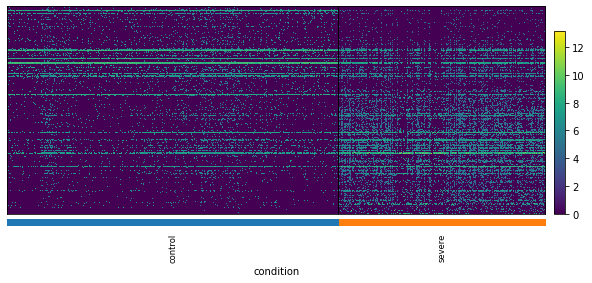

In [ ]:
plot_heatmap(adata_pp, adata_pp.varm['edgeR_monocytes'], 'Monocytes')

We can see that the differences in expressions are clearer for granulocytes than for monocytes. Because there are also differences in gene expression within the cell populations (blocks of brighter/darker columns within condition), it probably indicates some substructures in both populations that are not captured but the current cell type annotation which may be interesting to investigate further.

Next, we define the helper plotting function for the volcano plots.

In [ ]:
def volcano_plot(result, title="", genes_to_annotate=[]):
    result['-logQ'] = -np.log(result['FDR'])
    lowqval_de = result.loc[abs(result['logFC']) > LOG_FOLD_CHANGE]
    other_de = result.loc[abs(result['logFC']) <= LOG_FOLD_CHANGE]

    fig, ax = plt.subplots()
    sns.regplot(other_de['logFC'], other_de['-logQ'], fit_reg=False, scatter_kws={'s':6})
    sns.regplot(lowqval_de['logFC'], lowqval_de['-logQ'], fit_reg=False, scatter_kws={'s':6})
    ax.set_xlabel("log2 FC", fontsize=20)
    ax.set_ylabel("-log Q-value", fontsize=20)
    ax.tick_params(labelsize=15)
    
    # genes to annotate
    labels = []
    # positions
    x = []
    y = []
    # leave the genes that were used in the DE analysis and were present in the original data in the first place
    for gene in genes_to_annotate:
        if gene in result.index and not np.isnan(result['logFC'][gene]): 
            labels.append(gene)
            x.append(result['logFC'][gene])
            y.append(result['-logQ'][gene])

    for i, txt in enumerate(labels):
        ax.annotate(txt, (x[i], y[i]))
    
    plt.title(title)
    plt.show()

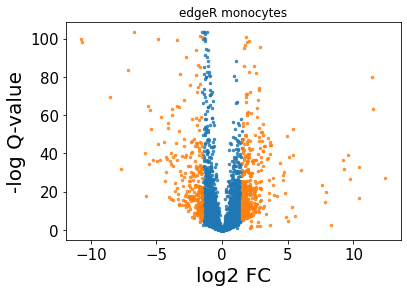

In [ ]:
volcano_plot(adata_pp.varm['edgeR_monocytes'], 'edgeR monocytes')

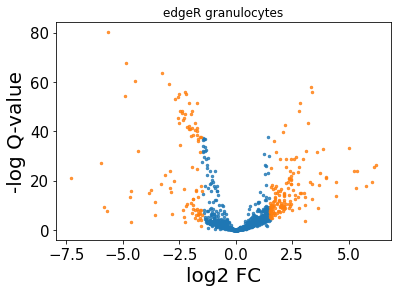

In [ ]:
volcano_plot(adata_pp.varm['edgeR_granulocytes'], 'edgeR granulocytes')

We will investigate volcano plots in more detail later and compare them with volcano plots for MAST.

In [ ]:
# just for me, will delete later
adata_pp.write('/storage/groups/ml01/workspace/anastasia.litinetskaya/bp/de_edgeR.h5ad')

... storing 'donor' as categorical
... storing 'condition' as categorical
... storing 'cell_identity' as categorical
... storing 'purification' as categorical
... storing 'cells' as categorical
... storing 'age' as categorical
... storing 'sex' as categorical
... storing 'group_per_sample' as categorical
... storing 'disease_stage' as categorical
... storing 'outcome' as categorical


### Notes on edgeR:
- Requires raw counts as input
- Requires pseudo-bulks from a single-cell experiment
- If there are several donors in the single-cell experiment and the user wants to account for the patient varianility, we recommend creating 2 or 3 pseudo-replicates for each patient and including patient information into the design matrix

## MAST-RE

MAST models single-cell gene expression with a two-part generalized linear model. One part models the discrete expression rate of each gene across cells, whereas the other part models the conditional continuous expression level 

The MAST framework models single-cell gene expression using a two-part generalized linear model. One component of MAST models the discrete expression rate of each gene across cells, while the other component models the conditional continuous expression level (conditional on the gene being expressed).
For more details please read the original publication CITE IT.

MAST takes normalized counts as input, so we first take the 'counts' layer and then perform the normalization step.

In [ ]:
adata.X = adata.layers['counts'].copy()

In [ ]:
sc.pp.normalize_total(adata, target_sum=1e6)
sc.pp.log1p(adata)

We need to filter out genes that are expressed in a small number of cells (3 in this case) for each subpopulation as the model needs to be able to estimate the variance for each gene.

In [ ]:
def prep_anndata(adata_):

    def fix_dtypes(adata_):
        df = pd.DataFrame(adata_.X.A, index = adata_.obs_names, columns = adata_.var_names)
        df = df.join(adata_.obs)
        return sc.AnnData(df[adata_.var_names], obs=df.drop(columns=adata_.var_names))
    
    adata_ = fix_dtypes(adata_)
    sc.pp.filter_genes(adata_, min_cells=3)
    return adata_

We again run the MAST pipeline for granulocytes and monocytes so subset the full data to two subpopulations.

In [ ]:
adata_gran = adata[adata.obs['cell_identity'] == 'Granulocytes'].copy()
adata_mono = adata[adata.obs['cell_identity'] == 'Monocytes'].copy()

Next we filter both objects as mentioned above.

In [ ]:
%%time
adata_gran = prep_anndata(adata_gran)
adata_gran

CPU times: user 1.77 s, sys: 527 ms, total: 2.3 s
Wall time: 2.3 s


AnnData object with n_obs × n_vars = 4185 × 16217
    obs: 'donor', 'condition', 'cell_identity', 'platform', 'purification', 'cells', 'age', 'sex', 'group_per_sample', 'who_per_sample', 'disease_stage', 'outcome', 'n_genes'
    var: 'n_cells'

In [ ]:
%%time
adata_mono = prep_anndata(adata_mono)
adata_mono

CPU times: user 25.9 s, sys: 7.95 s, total: 33.9 s
Wall time: 33.9 s


AnnData object with n_obs × n_vars = 23615 × 22315
    obs: 'donor', 'condition', 'cell_identity', 'platform', 'purification', 'cells', 'age', 'sex', 'group_per_sample', 'who_per_sample', 'disease_stage', 'outcome', 'n_genes'
    var: 'n_cells'

As is the case whenever multiple statistical tests are performed, the obtained p-values for DGE tests over conditions must be corrected for multiple testing using, for example, a Benjamini-Hochberg correction9,22.

Similarly to edgeR analysis, we define a separate function that we use for the analysis:
- `find_de_MAST_RE` takes a SingleCellExperiment object as input and runs MAST with RE pipeline. The output of the function is table (panda's DataFrame in python) which contains results of the analysis, e.g. log-fold change, p-value and FDR-corrected value for each gene.

In [ ]:
%%R
find_de_MAST_RE <- function(adata_){
    # create a MAST object
    sca <- SceToSingleCellAssay(adata_, class = "SingleCellAssay")
    print("Dimensions before subsetting:")
    print(dim(sca))
    print("")
    # keep genes that are expressed in more than 10% of all cells
    sca <- sca[freq(sca)>0.1,]
    print("Dimensions after subsetting:")
    print(dim(sca))
    print("")
    # add a column to the data which contains scaled number of genes that are expressed in each cell
    cdr2 <- colSums(assay(sca)>0)
    colData(sca)$ngeneson <- scale(cdr2)
    # store the condition that we are interested in as factors
    cond <- factor(colData(sca)$condition)
    colData(sca)$condition <- cond
    # same for donors (which we need to model random effects)
    donor <- factor(colData(sca)$donor)
    colData(sca)$donor <- donor
    # define and fit the model
    zlmCond <- zlm(formula = ~ngeneson + condition + (1 | donor), 
                   sca=sca, 
                   method='glmer', 
                   ebayes=F, 
                   strictConvergence=F,
                   fitArgsD=list(nAGQ = 0)) # to speed up calculations
    
    # perform likelihood-ratio test for the condition that we are interested in
    summaryCond <- summary(zlmCond, doLRT='conditionsevere')
    # get the table with log-fold changes and p-values
    summaryDt <- summaryCond$datatable
    result <- merge(summaryDt[contrast=='conditionsevere' & component=='H',.(primerid, `Pr(>Chisq)`)], # p-values
                     summaryDt[contrast=='conditionsevere' & component=='logFC', .(primerid, coef)],
                     by='primerid') # logFC coefficients
    # MAST uses natural logarithm so we convert the coefficients to log2 base to be comparable to edgeR
    # comment from N: this notebook was run without this line of code as Leander just pointed this out to me, 
    # but we'll rerun everything again anyway so shouldn't matter that much
    result[,coef:=result[,coef]/log(2)]
    # do multiple testing correction
    result[,FDR:=p.adjust(`Pr(>Chisq)`, 'fdr')]
    result = result[result$FDR<0.01,, drop=F]

    result <- stats::na.omit(as.data.frame(result))
    return(result)
}

We run the pipeline for monocytes.

In [ ]:
%%time
%%R -i adata_mono -o res_mono
res_mono <- find_de_MAST_RE(adata_mono)

[1] "Dimensions before subsetting:"
[1] 22315 23615
[1] ""
[1] "Dimensions after subsetting:"
[1]  3497 23615
[1] ""
CPU times: user 5h 12min 57s, sys: 1h 6min 21s, total: 6h 19min 19s
Wall time: 5h 16min 43s


We run the pipeline for granulocytes.

In [ ]:
%%time
%%R -i adata_gran -o res_gran
res_gran <- find_de_MAST_RE(adata_gran)

[1] "Dimensions before subsetting:"
[1] 16217  4185
[1] ""
[1] "Dimensions after subsetting:"
[1] 1282 4185
[1] ""
CPU times: user 24min 4s, sys: 32.5 s, total: 24min 36s
Wall time: 24min 36s


We define a helper function to create a dataframe with MAST output that can be used with our plotting functions.

In [ ]:
def rename_df(result, adata):
    result = pd.DataFrame(index=adata.var_names).join(result.set_index('primerid'), how='outer')
    # sort by adata.var_names so that the gene order is the same
    result = result.T[adata.var_names].T
    # rename columns so MAST column names are consistent with edgeR to make plotting easier
    result = result.rename(columns={"coef": "logFC", "Pr(>Chisq)": "PValue"})
    return result

Next, we clean the output and store in the original AnnData object.

In [ ]:
res_gran = rename_df(res_gran, adata)
adata.varm['MAST_granulocytes'] = res_gran

In [ ]:
res_mono = rename_df(res_mono, adata)
adata.varm['MAST_monocytes'] = res_mono

Let us take a look at the output table for MAST:

In [ ]:
adata.varm['MAST_granulocytes'].dropna().sort_values('logFC', ascending=False)

,PValue,logFC,FDR,-logQ
MNDA,3.937059e-28,5.858330,1.364138e-26,59.556690
S100P,3.121795e-19,5.660107,3.420633e-18,40.216706
LCP1,2.125467e-19,4.661601,2.369434e-18,40.583881
GCA,1.019662e-20,4.426935,1.210376e-19,43.558186
IGKC,1.960420e-15,4.225049,1.561030e-14,31.790845
...,...,...,...,...
RPL23A,1.227711e-33,-5.362029,1.748806e-31,70.821204
RPL10A,2.978284e-29,-5.592252,1.363628e-27,61.859648
CD52,1.683573e-24,-6.058712,2.956631e-23,51.875407
RPL36A,6.136282e-34,-6.472752,1.104943e-31,71.280345


In [ ]:
adata.varm['MAST_monocytes'].dropna().sort_values('logFC', ascending=False)

,PValue,logFC,FDR,-logQ
NAMPT,7.893098e-25,5.781319,2.075351e-23,52.229327
IGKC,2.195855e-12,4.203570,9.229455e-12,25.408621
CXCL8,3.930821e-17,4.108723,3.462489e-16,35.599374
FOSB,3.077985e-16,4.093683,2.457468e-15,33.639645
PLEK,5.385657e-24,3.967789,1.317038e-22,50.381487
...,...,...,...,...
HLA-DRB1,4.615806e-22,-5.291862,8.495512e-21,46.214749
CD52,1.083854e-19,-5.303056,1.398611e-18,41.111052
HLA-DRA,7.359628e-28,-6.009360,2.523198e-26,58.941685
RPL36A,2.484223e-35,-6.452267,2.802364e-33,74.954845


Here we again plot the heatmaps and volcano plots.

Plotting 246 genes...


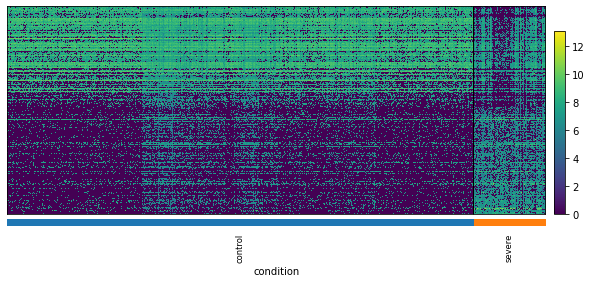

In [ ]:
plot_heatmap(adata, adata.varm['MAST_granulocytes'], 'Granulocytes')

Plotting 389 genes...


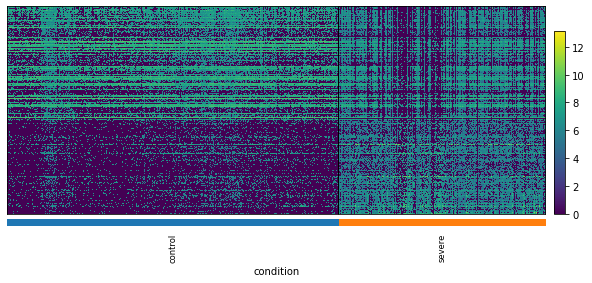

In [ ]:
plot_heatmap(adata, adata.varm['MAST_monocytes'], 'Monocytes')

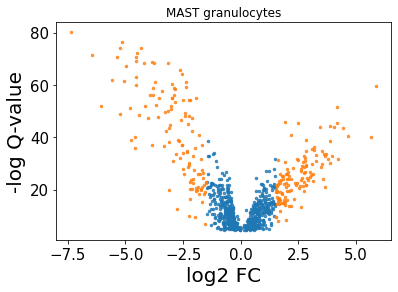

In [ ]:
volcano_plot(adata.varm['MAST_granulocytes'], 'MAST granulocytes')

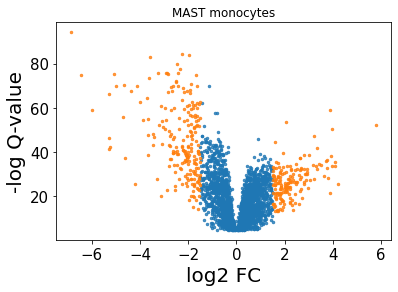

In [ ]:
volcano_plot(adata.varm['MAST_monocytes'], 'MAST monocytes')

We note the differences in the number of DE genes detected by MAST and edgeR (with FDR-corrected p-value of <0.01 and log-fold change >1.5 for both methods): 246 vs 233 for granulocytes and 389 vs 662 for monocytes. It is well known that in general, the consensus and robustness across datasets for DGE tools is low5,6.

@L and @S: comments on the following? manually make labels not overlap? stuff to add/remove?

In the original publication, the authors found several gene markers for severe COVID-19 in both monocytes and granulocytes. We finally plot these markers for both explored methods to see if our analysis alligns with the findings of the paper.

In [ ]:
monocytes_genes = ['CD163', 'PLAC8', 'HLA-DRA', 'ITGAX', 'CD226', 'CD69', 'CD38', 'FAS', 'CXCR3', 'S100A12', 'CXCL8', 'SELL', 'CD163', 'MPO', 'ISG15', 'IFI6']

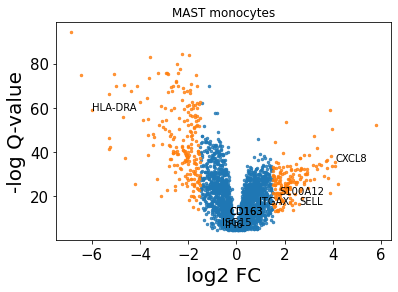

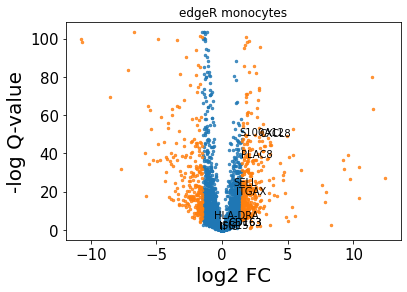

In [ ]:
volcano_plot(adata.varm['MAST_monocytes'], 'MAST monocytes', monocytes_genes)
volcano_plot(adata_pp.varm['edgeR_monocytes'], 'edgeR monocytes', monocytes_genes)

We observe that CXCL8, S100A12 and SELL are detected by both methods as upregulated in monocytes in severe COVID-19. HLA-DRA is only downregulated in MAST results, but only edgeR detects PLAC8.

In [ ]:
granulocytes_genes = ['CD274', 'FCGR1A', 'SELL', 'TNFRSF11A', 'TNFSF11', 'S100A8', 'S100A9', 'S100A4', 'S100A12', 'ARG1']

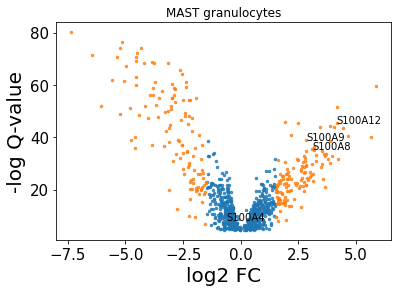

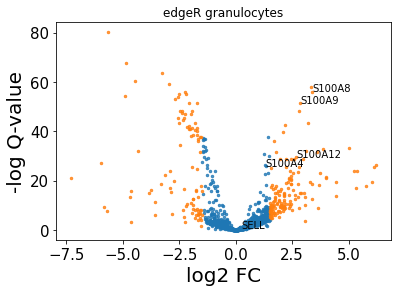

In [ ]:
volcano_plot(adata.varm['MAST_granulocytes'], 'MAST granulocytes', granulocytes_genes)
volcano_plot(adata_pp.varm['edgeR_granulocytes'], 'edgeR granulocytes', granulocytes_genes)

Both methods detect S100A genes as upregulated, but only edgeR detects S100A4.

We don't see the rest of the genes, i.e. CD274, FCGR1A, TNFRSF11A, TNFSF11, ARG1, on the volcano plots. It means that they were filtered out by both methods in the filtering step and hence the models were not fitted for these genes and so can't compute the p-values for them.

In [ ]:
# will remove later
adata.write('/storage/groups/ml01/workspace/anastasia.litinetskaya/bp/de_mast.h5ad')

## Key Takeaways

Repeated measurements (cells) from the same experimental subject in scRNA-seq introduce correlations between measurements, which need to be adjusted by modeling the experimental units as Random Effect to mitigate the pseudoreplication issue. Account for them through a sum or mean aggregation (pseudobulk methods - by fixed- or random effect terms) or by accounting for individual as a random effect (single-cell methods) to mitigate the pseudoreplication issue.


Determine the major axis of variation with exploratory analysis to construct an appropriate design matrix to better model the variations in the data.


Statistical power is best increased with more samples in the experimental design.

## Quiz

1. What is differential gene expression and in which cases are we interested in testing for it?

2. What is the 'pseudoreplication' problem and how can it be circumvented?

3. What is the 'multiple testing' problem and how can it be eluded?

## References

```{bibliography}
:filter: docname in docnames
```